#  Классификация изображений с помощью сверточных нейронных сетей

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Deep Learning with PyTorch (2020) Авторы: Eli Stevens, Luca Antiga, Thomas Viehmann
* https://pytorch.org/docs/stable/nn.html#convolution-layers
* https://pytorch.org/vision/0.16/transforms.html#v2-api-reference-recommended
* https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
* https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html
* https://kozodoi.me/blog/20210308/compute-image-stats
* https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.matshow.html

## Задачи для совместного разбора

1\. Рассмотрите основные возможности по созданию датасетов из `torchvision` и примеры работы основных слоев для создания сверточных нейронных сетей для анализа изображений.

In [1]:
import torch as th
import torchvision
import torchvision.transforms.v2 as T

In [2]:
trainset = torchvision.datasets.CIFAR10(
    root='./cifar10',
    download=True,
    train=True,
)

Files already downloaded and verified


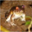

In [3]:
trainset[0][0]

In [4]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

trainset = torchvision.datasets.CIFAR10(
    root='./cifar10',
    download=True,
    train=True,
    transform=transform
)

/Users/admin/Финашка 2024 - 3 год/Deep-Learning/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Files already downloaded and verified


In [5]:
trainset[0][0].shape

torch.Size([3, 32, 32])

2\. Реализуйте типовую архитектуру CNN для классификации изображений.

In [6]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=6,
                kernel_size=3,
            ),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(
                in_channels=6,
                out_channels=2,
                kernel_size=3,
            ),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Linear(72, 10)


    def forward(self, X):
        out = self.conv_block1(X)
        out = self.conv_block2(out)

        out = out.flatten(start_dim=1)
        out = self.classifier(out)

        return out

In [7]:
from torch.utils.data import DataLoader

loader = DataLoader(trainset, batch_size=16)
X, y = next(iter(loader))

In [8]:
X.shape

torch.Size([16, 3, 32, 32])

In [9]:
model = CNN()
out = model(X)

In [10]:
out.shape

torch.Size([16, 10])

In [11]:
conv1 = nn.Conv2d(3, 6, (5, 7))
conv1.weight.shape

torch.Size([6, 3, 5, 7])

## Задачи для самостоятельного решения

<p class='task' id='1'></p>

1\. Создайте датасет `CatBreeds` на основе данных из архива `cat_breeds_4.zip`. Используя преобразования `torchvision`, приведите картинки к размеру 300х300 и нормализуйте значения интенсивности пикселей (рассчитайте статистику для нормализации отдельно). Выведите на экран количество картинок в датасете,  размер одной картинки, количество уникальных классов. Разбейте датасет на обучающее и тестовое множество в соотношении 80 на 20%.

При расчете статистики для нормализации считайте, что вы можете загрузить весь набор данных в память сразу. Однако рекомендуется реализовать подход для получения статистики на основе батчей, так как такое решение в перспективе может позволить обработать датасет, который не помещается в память целиком.

- [ ] Проверено на семинаре

In [12]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import numpy as np

In [13]:
dataset_path = './../data/cat_breeds_4'

transform_initial = T.Compose([
    T.Resize((300, 300)),
    T.ToTensor()
])

cat_breeds_dataset = ImageFolder(root=dataset_path, transform=transform_initial)
loader = DataLoader(cat_breeds_dataset, batch_size=64, shuffle=False)

mean = 0.0
std = 0.0
total_images = 0

for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images += batch_samples

mean /= total_images
std /= total_images

print(f'Среднее значение: {mean}')
print(f'Стандартное отклонение: {std}')

Среднее значение: tensor([0.5000, 0.4514, 0.4066])
Стандартное отклонение: tensor([0.2324, 0.2273, 0.2228])


In [14]:
transform_normalized = T.Compose([
    T.Resize((300, 300)),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

cat_breeds_normalized = ImageFolder(root=dataset_path, transform=transform_normalized)

print(f'Количество изображений в датасете: {len(cat_breeds_normalized)}')
print(f'Размер одной картинки: {cat_breeds_normalized[0][0].shape}')
print(f'Количество уникальных классов: {len(cat_breeds_normalized.classes)}')

train_dataset, test_dataset = random_split(cat_breeds_normalized, [0.8, 0.2])
train_dataloader = DataLoader(train_dataset, batch_size=24, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=24, shuffle=False)
print(f'Размер обучающего множества: {len(train_dataset)}')
print(f'Размер тестового множества: {len(test_dataset)}')

Количество изображений в датасете: 4000
Размер одной картинки: torch.Size([3, 300, 300])
Количество уникальных классов: 4
Размер обучающего множества: 3200
Размер тестового множества: 800


<p class='task' id='2'></p>

2\. Решите задачу классификации на основе датасета из предыдущего задания, не используя сверточные слои. Постройте график изменения значения функции потерь на обучающем множестве в зависимости от номера эпохи, графики изменения метрики accuracy на обучающем и тестовом множестве в зависимости от эпохи. Выведите на экран итоговое значение метрики accuracy на обучающем и тестовом множестве. Выведите на экран количество параметров модели.

- [ ] Проверено на семинаре

In [15]:
from torch import optim

model = nn.Sequential(
    nn.Linear(np.prod(cat_breeds_normalized[0][0].shape), 8),
    nn.ReLU(),
    nn.Linear(8, len(cat_breeds_normalized.classes)),
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [16]:
loss_train = []
loss_test = []
accuracy_train = []
accuracy_test = []

In [17]:
import torchmetrics as tm
from tqdm import tqdm

ecpochs = 2
run_data = []
metric = tm.Accuracy(
    task='multiclass',
    num_classes=len(cat_breeds_normalized.classes)
)
for epoch in range(ecpochs):
    model.train()
    y_pred_epoch_train = []
    y_true_epoch_train = []

    y_pred_epoch_test = []
    y_true_epoch_test = []

    loss_epoch_train = []
    loss_epoch_test = []
    
    for X_batch, y_batch in tqdm(train_dataloader, desc=f'Эпоха {epoch} – обучение'):
        y_pred = model(X_batch.view(X_batch.size(0), -1))
        
        loss = criterion(y_pred, y_batch)
        
        y_pred_epoch_train.extend(y_pred.detach().argmax(dim=1).numpy().tolist())
        y_true_epoch_train.extend(y_batch.detach().numpy().tolist())
        loss_epoch_train.append(loss.detach().numpy().item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    model.eval()
    with th.no_grad():
        for X_batch, y_batch in tqdm(test_dataloader, desc=f'Эпоха {epoch} – тестирование'):
            y_pred = model(X_batch.view(X_batch.size(0), -1))
            loss = criterion(y_pred, y_batch)
            y_pred_epoch_test.extend(y_pred.detach().argmax(dim=1).numpy().tolist())
            y_true_epoch_test.extend(y_batch.detach().numpy().tolist())
            loss_epoch_test.append(loss.detach().numpy().item())
    
    accuracy_train = metric(th.tensor(y_pred_epoch_train), th.tensor(y_true_epoch_train)).item()
    metric.reset()
    accuracy_test = metric(th.tensor(y_pred_epoch_test), th.tensor(y_true_epoch_test)).item()
    metric.reset()
    loss_train = th.mean(th.tensor(loss_epoch_train)).item()
    loss_test = th.mean(th.tensor(loss_epoch_test)).item()
    run_data.append((epoch, loss_train, loss_test, accuracy_train, accuracy_test))
    
    print(f'Epoch {epoch} | Train loss: {loss_train:.4f} | Test loss: {loss_test:.4f}\n\t| Train accuracy: {accuracy_train:.4f} | Test Accuracy: {accuracy_test:.4f}')

Эпоха 0 – тестирование: 100%|██████████| 34/34 [00:02<00:00, 16.20it/s]


Epoch 0 | Train loss: 13.1211 | Test loss: 12.7887
	| Train accuracy: 0.3316 | Test Accuracy: 0.3350


Эпоха 1 – тестирование: 100%|██████████| 34/34 [00:01<00:00, 17.66it/s]

Epoch 1 | Train loss: 7.6472 | Test loss: 8.6989
	| Train accuracy: 0.3778 | Test Accuracy: 0.3388


In [18]:
import pandas as pd

data = pd.DataFrame(
    run_data,
    columns=[
        'epoch', 'train_loss', 'test_loss',
        'train_accuracy', 'test_accuracy'
    ]
)
data

epoch  train_loss  test_loss  train_accuracy  test_accuracy
0      0   13.121098  12.788662        0.331562        0.33500
1      1    7.647235   8.698867        0.377813        0.33875

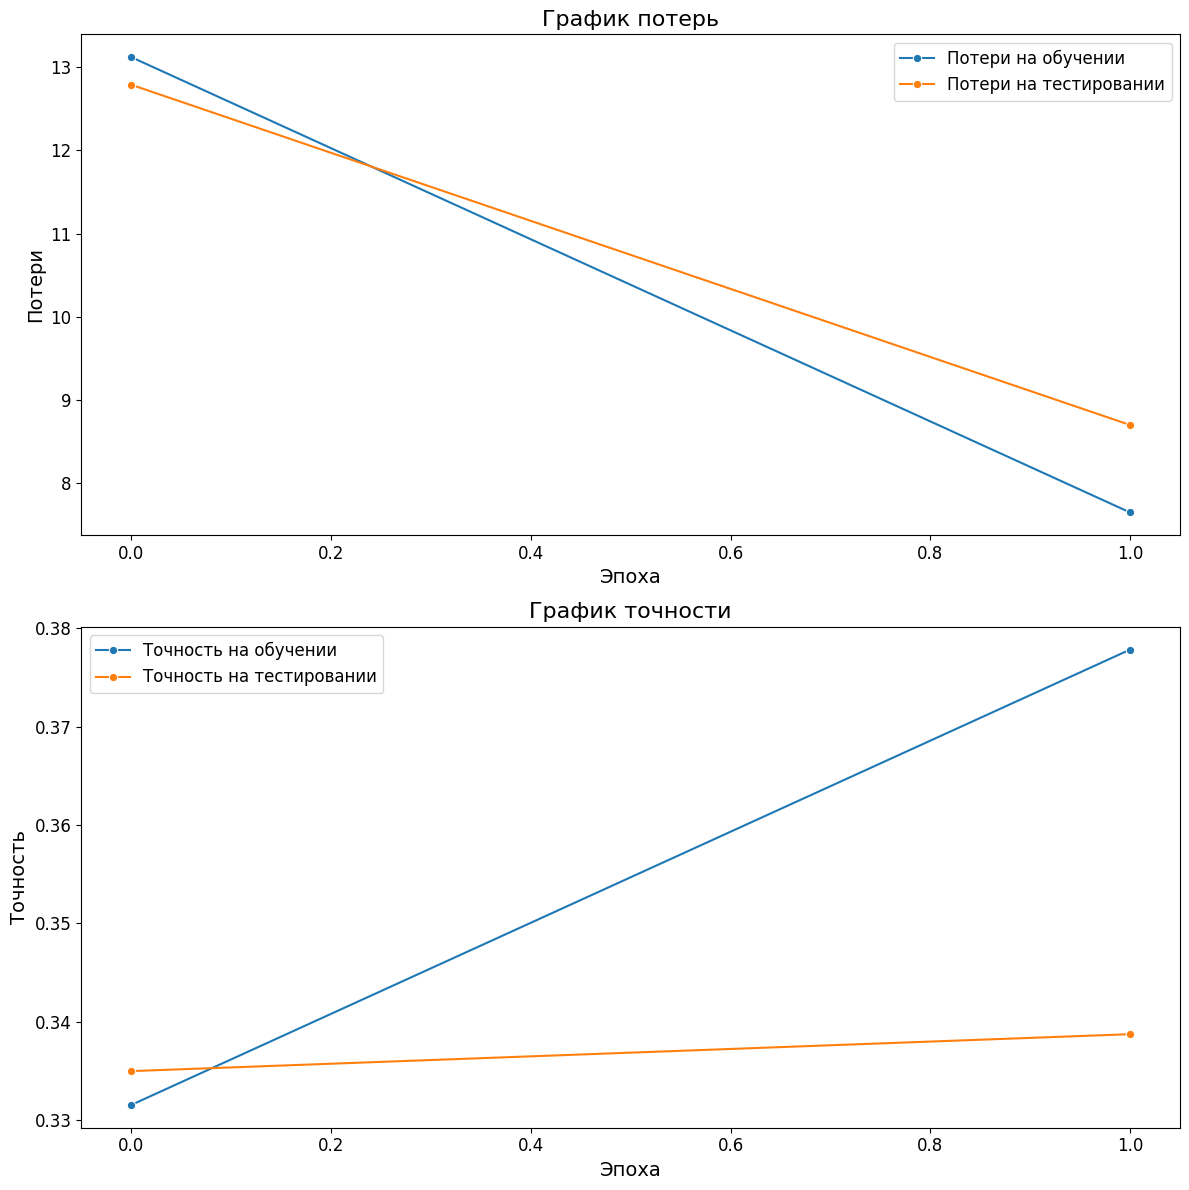

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(12, 12))
sns.lineplot(ax=axs[0], x=data['epoch'], y=data['train_loss'], label='Потери на обучении', marker='o')
sns.lineplot(ax=axs[0], x=data['epoch'], y=data['test_loss'], label='Потери на тестировании', marker='o')
axs[0].set_title('График потерь', fontsize=16)
axs[0].set_xlabel('Эпоха', fontsize=14)
axs[0].set_ylabel('Потери', fontsize=14)
axs[0].legend(fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=12)

sns.lineplot(ax=axs[1], x=data['epoch'], y=data['train_accuracy'], label='Точность на обучении', marker='o')
sns.lineplot(ax=axs[1], x=data['epoch'], y=data['test_accuracy'], label='Точность на тестировании', marker='o')
axs[1].set_title('График точности', fontsize=16)
axs[1].set_xlabel('Эпоха', fontsize=14)
axs[1].set_ylabel('Точность', fontsize=14)
axs[1].legend(fontsize=12)
axs[1].tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()

In [20]:
print(f'Финальная точность на обучающем множестве: {accuracy_train:.4f}')
print(f'Финальная точность на тестовом множестве: {accuracy_test:.4f}')
num_params = sum(p.numel() for p in model.parameters())
print(f'Количество параметров в модели: {num_params}')

Финальная точность на обучающем множестве: 0.3778
Финальная точность на тестовом множестве: 0.3388
Количество параметров в модели: 2160044


<p class='task' id='3'></p>

3\. Напишите функцию, которая выбирает несколько изображений из переданного набора данных и выводит их на экран в виде сетки с указанием над ними названия правильного класса и класса, предсказанного моделью. Воспользовавшись данной функцией, выведите прогнозы итоговой модели из предыдущей задачи по 6 случайным картинкам.

```
def show_examples(model, dataset, k=6):
    pass
```

- [ ] Проверено на семинаре

In [21]:
import random

def show_examples(model, dataset, k=6, view=True):
    indices = random.sample(range(len(dataset)), k)
    images, labels = zip(*[dataset[i] for i in indices])
    images = th.stack(images)
    labels = th.tensor(labels)

    model.eval()
    with th.no_grad():
        images2 = images.view(images.size(0), -1) if view else images
        outputs = model(images2)
        preds = outputs.argmax(dim=1)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        ax.imshow(images[i].permute(1, 2, 0).numpy())
        ax.set_title(f'True: {dataset.classes[labels[i]]}\nPred: {dataset.classes[preds[i]]}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.151494..2.6629987].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1008742..2.6629987].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4090703..2.6629987].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.084001..2.6629987].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.151494..2.6629987].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1008742..2.6629987].


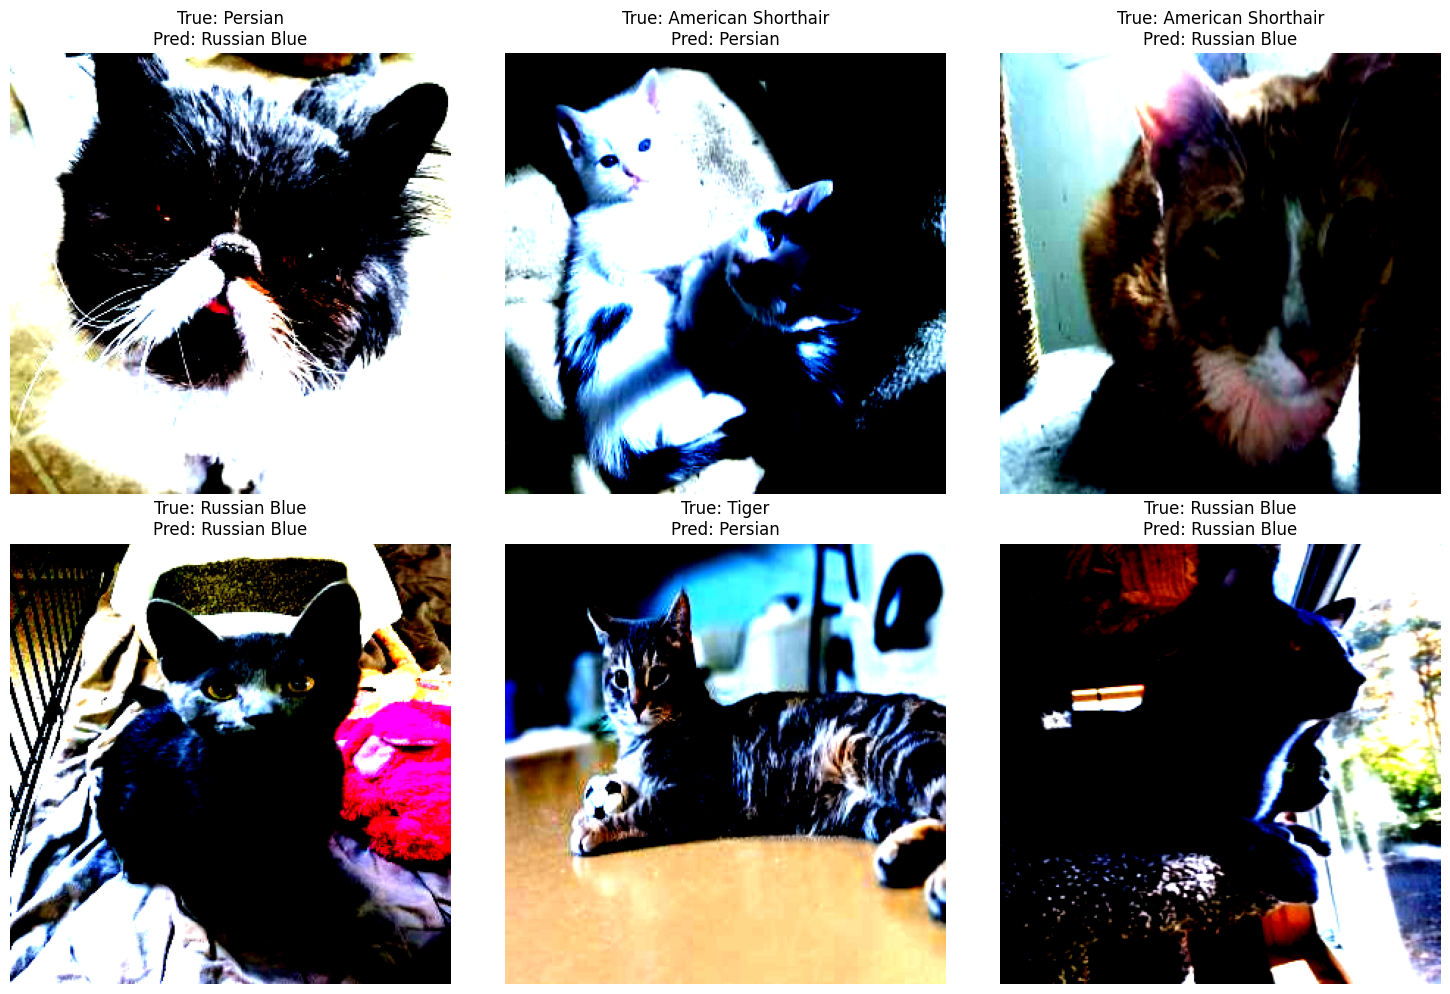

In [22]:
show_examples(model, cat_breeds_normalized)

<p class='task' id='4'></p>

4\. Решите задачу классификации на основе датасета из первого задания, используя сверточные слои. Постройте график изменения значения функции потерь на обучающем множестве в зависимости от номера эпохи, графики изменения метрики accuracy на обучающем и тестовом множестве в зависимости от эпохи. Выведите на экран итоговое значение метрики accuracy на обучающем и тестовом множестве. Выведите на экран количество параметров модели. Воспользовавшись функцией из предыдущего задания, выведите прогнозы итоговой модели по 6 случайным картинкам.

Сохраните веса обученной модели на диск.

- [ ] Проверено на семинаре

In [23]:
model = nn.Sequential(
    nn.Conv2d(3, 16, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(16, 32, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(32, 64, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Flatten(),
    nn.Linear(64 * 37 * 37, 128),
    nn.ReLU(),
    nn.Linear(128, len(cat_breeds_normalized.classes)),
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [24]:
loss_train = []
loss_test = []
accuracy_train = []
accuracy_test = []

In [25]:
ecpochs = 4
run_data = []
metric = tm.Accuracy(
    task='multiclass',
    num_classes=len(cat_breeds_normalized.classes)
)
for epoch in range(ecpochs):
    model.train()
    y_pred_epoch_train = []
    y_true_epoch_train = []

    y_pred_epoch_test = []
    y_true_epoch_test = []

    loss_epoch_train = []
    loss_epoch_test = []
    
    for X_batch, y_batch in tqdm(train_dataloader, desc=f'Эпоха {epoch} – обучение'):
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch)
        
        y_pred_epoch_train.extend(y_pred.detach().argmax(dim=1).numpy().tolist())
        y_true_epoch_train.extend(y_batch.detach().numpy().tolist())
        loss_epoch_train.append(loss.detach().numpy().item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    model.eval()
    with th.no_grad():
        for X_batch, y_batch in tqdm(test_dataloader, desc=f'Эпоха {epoch} – тестирование'):
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            y_pred_epoch_test.extend(y_pred.detach().argmax(dim=1).numpy().tolist())
            y_true_epoch_test.extend(y_batch.detach().numpy().tolist())
            loss_epoch_test.append(loss.detach().numpy().item())
    
    accuracy_train = metric(th.tensor(y_pred_epoch_train), th.tensor(y_true_epoch_train)).item()
    metric.reset()
    accuracy_test = metric(th.tensor(y_pred_epoch_test), th.tensor(y_true_epoch_test)).item()
    metric.reset()
    loss_train = th.mean(th.tensor(loss_epoch_train)).item()
    loss_test = th.mean(th.tensor(loss_epoch_test)).item()
    run_data.append((epoch, loss_train, loss_test, accuracy_train, accuracy_test))
    
    print(f'Epoch {epoch} | Train loss: {loss_train:.4f} | Test loss: {loss_test:.4f}\n\t| Train accuracy: {accuracy_train:.4f} | Test Accuracy: {accuracy_test:.4f}')

Эпоха 0 – тестирование: 100%|██████████| 34/34 [00:10<00:00,  3.34it/s]


Epoch 0 | Train loss: 1.3801 | Test loss: 1.2797
	| Train accuracy: 0.3281 | Test Accuracy: 0.4100


Эпоха 1 – тестирование: 100%|██████████| 34/34 [00:11<00:00,  3.05it/s]


Epoch 1 | Train loss: 1.2033 | Test loss: 1.1571
	| Train accuracy: 0.4731 | Test Accuracy: 0.5075


Эпоха 2 – тестирование: 100%|██████████| 34/34 [00:11<00:00,  2.98it/s]


Epoch 2 | Train loss: 1.0684 | Test loss: 1.1095
	| Train accuracy: 0.5431 | Test Accuracy: 0.5425


Эпоха 3 – тестирование: 100%|██████████| 34/34 [00:11<00:00,  2.97it/s]

Epoch 3 | Train loss: 0.9043 | Test loss: 1.1579
	| Train accuracy: 0.6275 | Test Accuracy: 0.5250


In [26]:
import pandas as pd

data = pd.DataFrame(
    run_data,
    columns=[
        'epoch', 'train_loss', 'test_loss',
        'train_accuracy', 'test_accuracy'
    ]
)
data

epoch  train_loss  test_loss  train_accuracy  test_accuracy
0      0    1.380076   1.279708        0.328125         0.4100
1      1    1.203302   1.157143        0.473125         0.5075
2      2    1.068445   1.109454        0.543125         0.5425
3      3    0.904312   1.157942        0.627500         0.5250

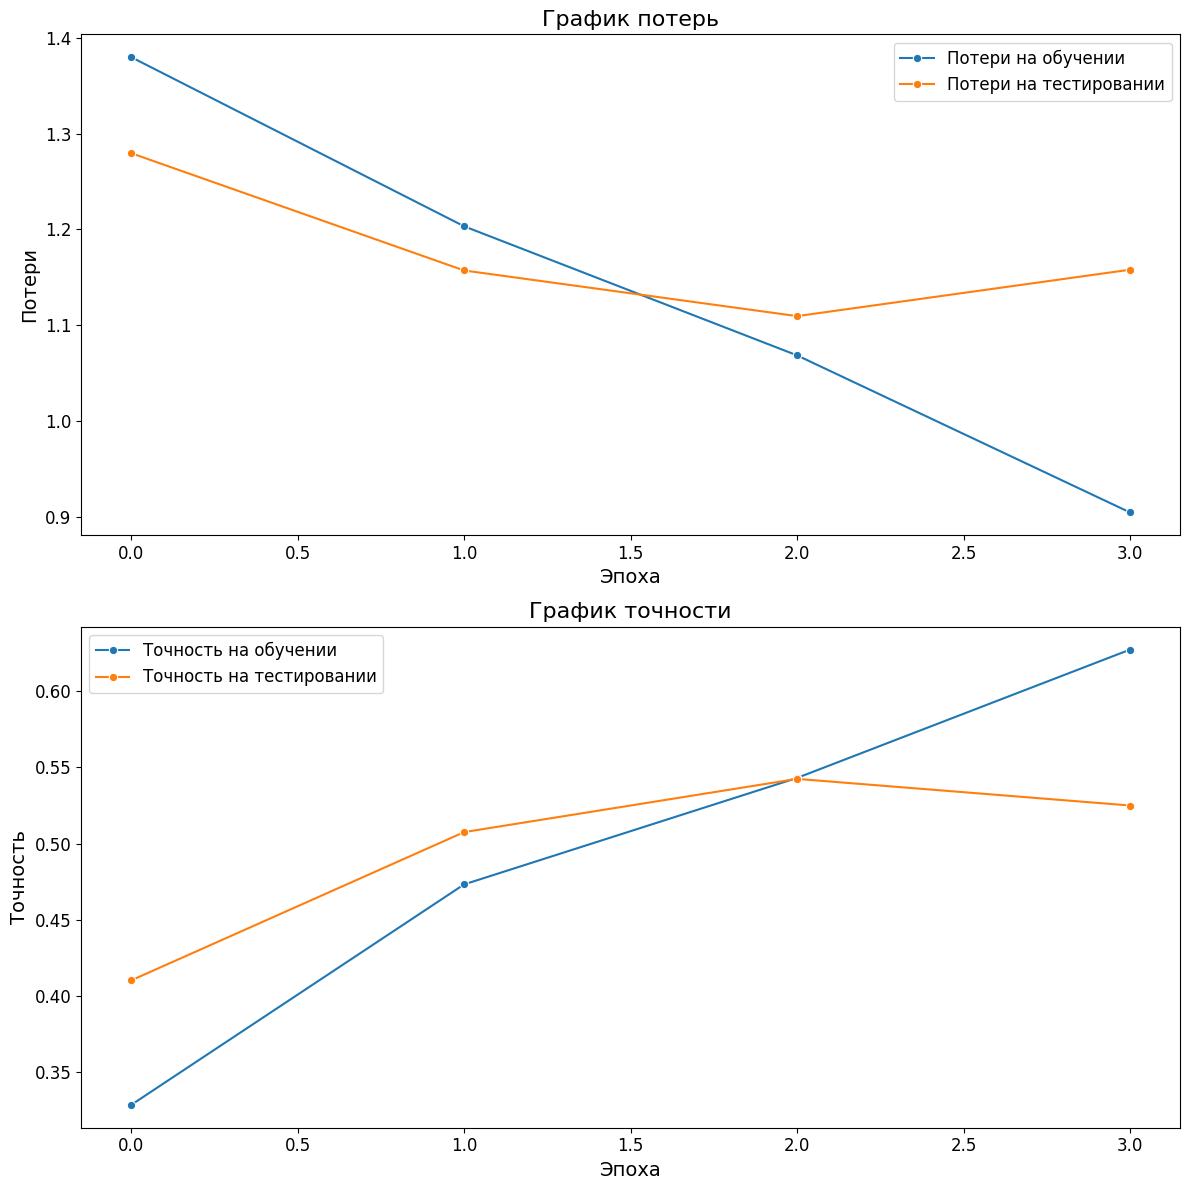

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(12, 12))
sns.lineplot(ax=axs[0], x=data['epoch'], y=data['train_loss'], label='Потери на обучении', marker='o')
sns.lineplot(ax=axs[0], x=data['epoch'], y=data['test_loss'], label='Потери на тестировании', marker='o')
axs[0].set_title('График потерь', fontsize=16)
axs[0].set_xlabel('Эпоха', fontsize=14)
axs[0].set_ylabel('Потери', fontsize=14)
axs[0].legend(fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=12)

sns.lineplot(ax=axs[1], x=data['epoch'], y=data['train_accuracy'], label='Точность на обучении', marker='o')
sns.lineplot(ax=axs[1], x=data['epoch'], y=data['test_accuracy'], label='Точность на тестировании', marker='o')
axs[1].set_title('График точности', fontsize=16)
axs[1].set_xlabel('Эпоха', fontsize=14)
axs[1].set_ylabel('Точность', fontsize=14)
axs[1].legend(fontsize=12)
axs[1].tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()

In [28]:
print(f'Финальная точность на обучающем множестве: {accuracy_train:.4f}')
print(f'Финальная точность на тестовом множестве: {accuracy_test:.4f}')
num_params = sum(p.numel() for p in model.parameters())
print(f'Количество параметров в модели: {num_params}')

Финальная точность на обучающем множестве: 0.6275
Финальная точность на тестовом множестве: 0.5250
Количество параметров в модели: 11239076


In [29]:
th.save(model.state_dict(), 'model_cnn.pt')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.151494..2.6629987].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.151494..1.6885557].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.151494..2.6629987].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.151494..1.9149642].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0671277..2.15119].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.151494..2.15119].


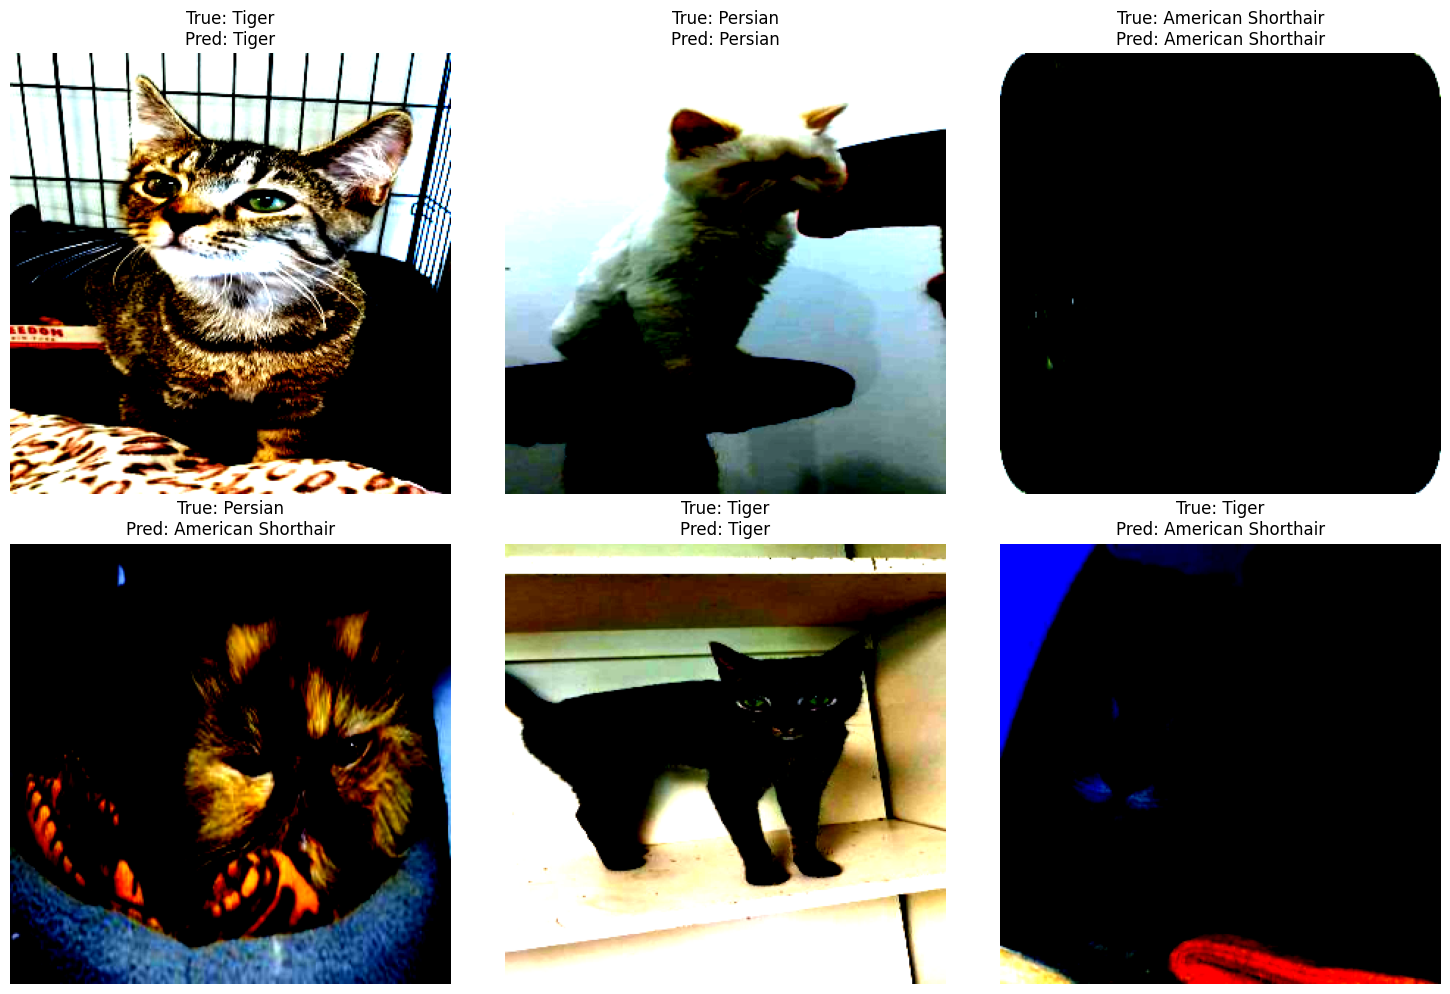

In [30]:
show_examples(model, cat_breeds_normalized, view=False)

<p class='task' id='5'></p>

5\. Проанализируйте обученную в предыдущей задаче модель, исследовав обученные ядра сверточных слоев. Выберите одно изображение из тестового набора данных и пропустите через первый сверточный слой модели. Визуализируйте полученные карты признаков.

- [ ] Проверено на семинаре

In [35]:
def visualize_feature_maps(model, image):
    model.eval()

    with th.no_grad():
        feature_maps = model[0](image.unsqueeze(0))
    
    feature_maps = feature_maps.squeeze(0).numpy()
    num_feature_maps = feature_maps.shape[0]
    
    plt.figure(figsize=(15, 15))
    rows = 4
    cols = (num_feature_maps + rows - 1) // rows  # Calculate the number of columns needed
    for i in range(num_feature_maps):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(feature_maps[i], cmap='viridis')
        plt.axis('off')
        plt.title(f'Feature Map {i + 1}')
    plt.show()

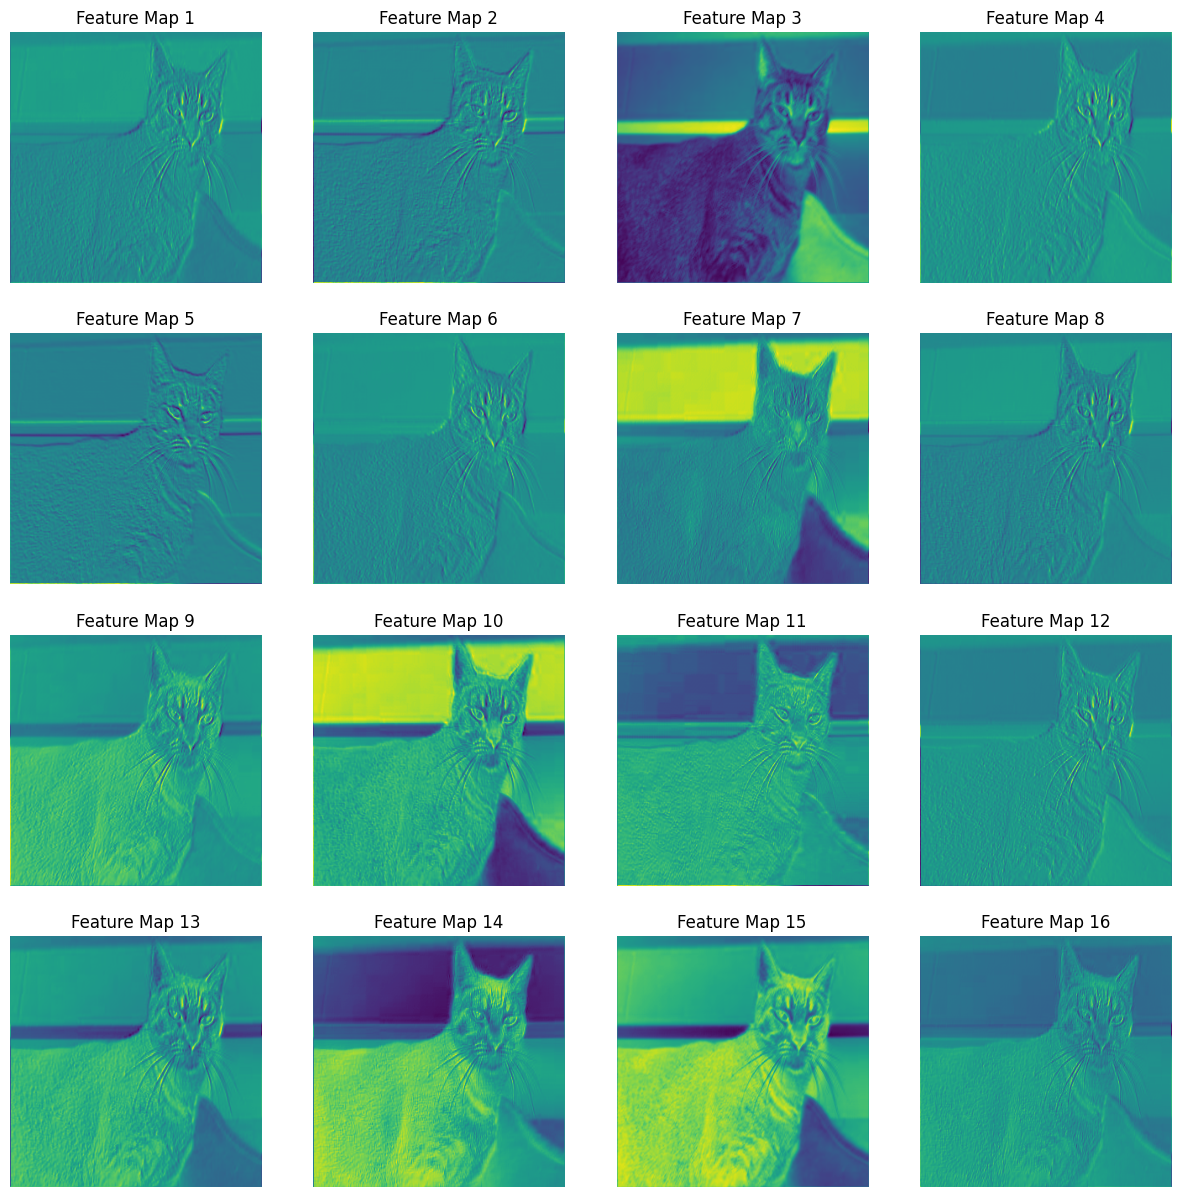

In [36]:
random_index = np.random.randint(len(test_dataset))
random_image, _ = test_dataset[random_index]
visualize_feature_maps(model, random_image)